In [1]:
# tools
import numpy as np
import pandas as pd

# data
from datasetsforecast.m3 import M3
from utilsforecast.plotting import plot_series

# models
import lightgbm as lgb

# forecast
from mlforecast import MLForecast
from mlforecast.target_transforms import Differences

# evaluate
from sklearn.metrics import mean_absolute_error

# data

In [7]:
Y_df_M3, _, _ = M3.load(directory = "./data", group = "Monthly")
print(Y_df_M3.head())
print()
print(Y_df_M3.shape)
print()
print(Y_df_M3["unique_id"].value_counts())

/Users/wangzf/Applications/miniconda3/envs/ts/lib/python3.11/site-packages/datasetsforecast/m3.py:108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(class_group.freq)


  unique_id         ds       y
0        M1 1990-01-31  2640.0
1        M1 1990-02-28  2640.0
2        M1 1990-03-31  2160.0
3        M1 1990-04-30  4200.0
4        M1 1990-05-31  3360.0

(167562, 3)

unique_id
M497     144
M630     144
M618     144
M619     144
M620     144
        ... 
M3        68
M6        68
M1        68
M1078     66
M1079     66
Name: count, Length: 1428, dtype: int64


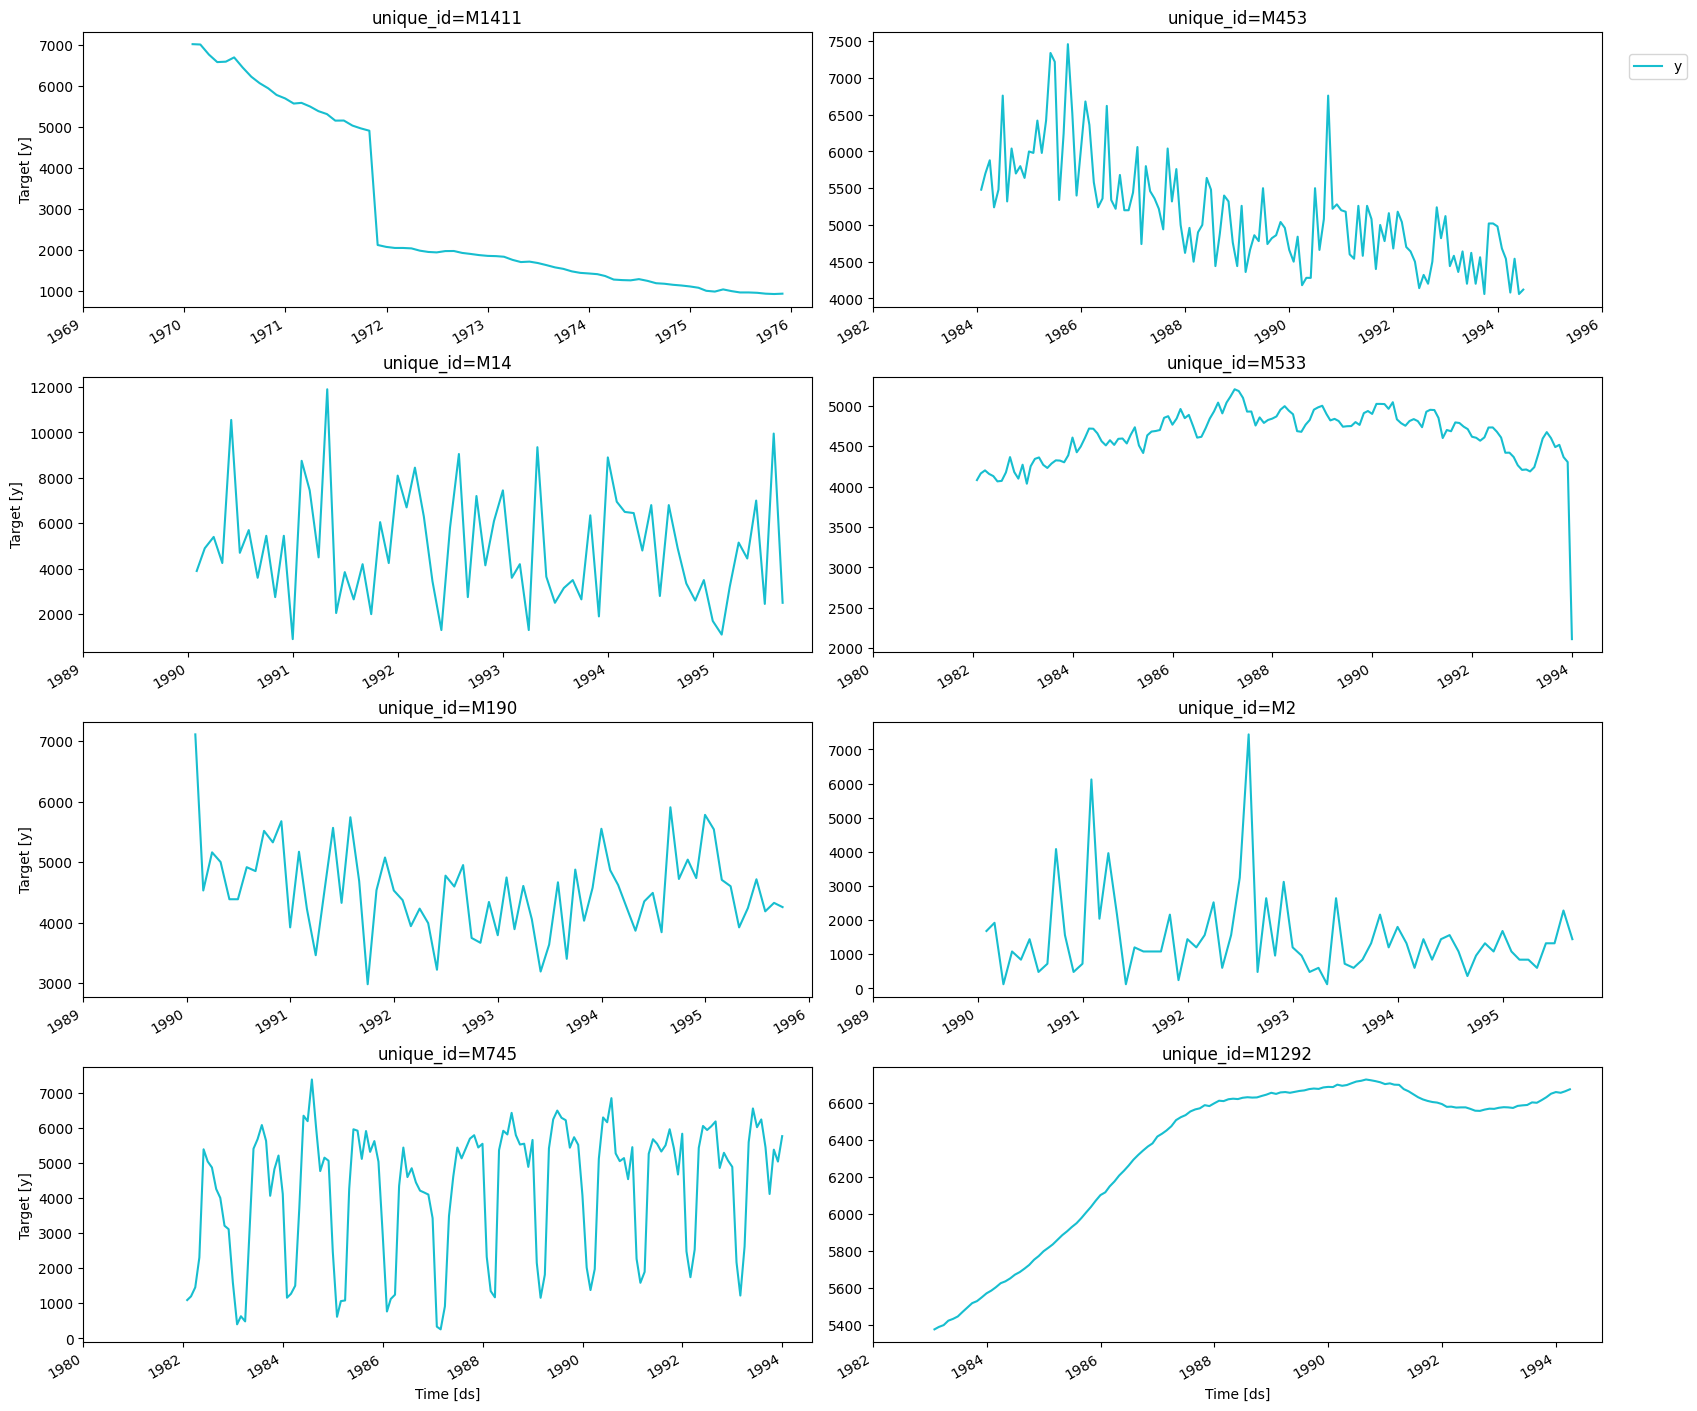

In [9]:
fig = plot_series(Y_df_M3, max_ids = 8)
fig

# model

In [10]:
fcst = MLForecast(
    models = [
        lgb.LGBMRegressor(verbosity = -1)
    ],
    freq = "MS",
    lags = range(1, 13),
    target_transforms = [
        Differences([1, 12])
    ],
)
fcst.fit(Y_df_M3)

MLForecast(models=[LGBMRegressor], freq=MS, lag_features=['lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12'], date_features=[], num_threads=1)

# transfer M3 to AirPassengers

## AirPassengers

In [11]:
Y_df = pd.read_csv(
    'https://datasets-nixtla.s3.amazonaws.com/air-passengers.csv', 
    parse_dates=['ds']
)

# train df
Y_train_df = Y_df[Y_df.ds <= '1959-12-31'] # 132 train
Y_test_df = Y_df[Y_df.ds > '1959-12-31']   # 12 test

## prediction

In [12]:
Y_hat_df = fcst.predict(h = 12, new_df = Y_train_df)
Y_hat_df.head()

,unique_id,ds,LGBMRegressor
0,AirPassengers,1960-01-01,422.740112
1,AirPassengers,1960-02-01,399.480225
2,AirPassengers,1960-03-01,458.220337
3,AirPassengers,1960-04-01,442.960419
4,AirPassengers,1960-05-01,461.700500


In [13]:
Y_hat_df = Y_test_df.merge(Y_hat_df, how = "left", on = ["unique_id", "ds"])
Y_hat_df.head()

,unique_id,ds,y,LGBMRegressor
0,AirPassengers,1960-01-01,417,422.740112
1,AirPassengers,1960-02-01,391,399.480225
2,AirPassengers,1960-03-01,419,458.220337
3,AirPassengers,1960-04-01,461,442.960419
4,AirPassengers,1960-05-01,472,461.700500


## evaluate

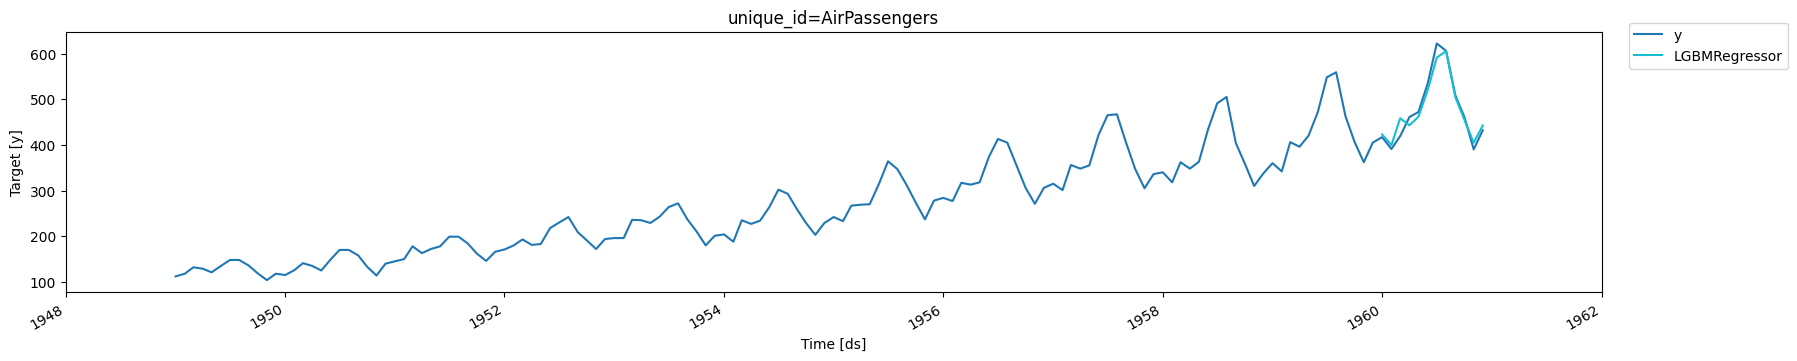

In [14]:
fig = plot_series(Y_train_df, Y_hat_df)
fig

In [15]:
y_true = Y_test_df.y.values
y_hat = Y_hat_df['LGBMRegressor'].values

print(f'LGBMRegressor     MAE: {mean_absolute_error(y_hat, y_true):.3f}')
print('ETS               MAE: 16.222')
print('AutoARIMA         MAE: 18.551')

LGBMRegressor     MAE: 13.560
ETS               MAE: 16.222
AutoARIMA         MAE: 18.551
